## Assingmnet 2 : Black Jack: A Cards Game

Objective: Implement the card game environment
Game Rules:
1) Cards are drawn from an infinite deck.
2) Cards are valued between 1 and 13.
3) Jack, Queen, King are treated as 11, 12, 13 respectively.
4) Both player and dealer start with one black card.
5) Player can hit or stick. Values are added/subtracted based on card color.
6) Player busts if their sum exceeds 21 or becomes less than 1.
7) Dealer sticks on 17 or higher and hits otherwise.
8) Rewards: +1 for player win, -1 for player loss, 0 for draw.

# Importing Liabraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from enum import Enum

# Action Space

In [2]:
class Action(Enum):
    HIT = 0
    STICK = 1


# State Class

In [3]:
class State:
    def __init__(self, dealer_sum, player_sum):
        self.dealer_sum = dealer_sum
        self.player_sum = player_sum
        self.is_terminal = player_sum > 21 or player_sum < 1


 # Environment Class

In [4]:
class Environment:
    def __init__(self):
        self.max_dealer_sum = 13
        self.max_player_sum = 21
        self.num_actions = len(Action)
    
    def draw_card(self):
        return np.random.randint(1, 14)
    
    def step(self, state, action):
        if action == Action.HIT:
            card = self.draw_card()
            new_player_sum = state.player_sum + (card if np.random.rand() < 2/3 else -card)
            if new_player_sum > 21 or new_player_sum < 1:
                return State(state.dealer_sum, new_player_sum), -1
            return State(state.dealer_sum, new_player_sum), 0
        else:
            dealer_sum = state.dealer_sum
            while dealer_sum < 17:
                card = self.draw_card()
                dealer_sum += (card if np.random.rand() < 2/3 else -card)
            if dealer_sum > 21:
                return state, 1
            elif dealer_sum > state.player_sum:
                return state, -1
            elif dealer_sum < state.player_sum:
                return state, 1
            else:
                return state, 0


<b>Monte Carlo Control</b>

Objective: Implement Monte Carlo Control

-Initialization:

1) Initialize value function (Q) to zero.
2) Use a time-varying step-size and ϵ-greedy exploration.

# Monte Carlo Control Agent

In [5]:
class MCControlAgent:
    def __init__(self, env, N0=100):
        self.env = env
        self.N0 = N0
        self.Q = np.zeros((env.max_dealer_sum + 1, env.max_player_sum + 1, env.num_actions))
        self.N = np.zeros_like(self.Q)
    
    def train(self, num_episodes):
        for _ in range(num_episodes):
            state = State(self.env.draw_card(), self.env.draw_card())
            action = np.random.choice(self.env.num_actions)
            states_actions = []
            while not state.is_terminal:
                if 0 <= state.dealer_sum <= self.env.max_dealer_sum and 0 <= state.player_sum <= self.env.max_player_sum:
                    next_state, reward = self.env.step(state, Action(action))
                    states_actions.append((state, action, reward))
                    state = next_state
                    action = np.random.choice(self.env.num_actions)
            G = 0
            for state, action, reward in reversed(states_actions):
                G = reward + G
                if 0 <= state.dealer_sum <= self.env.max_dealer_sum and 0 <= state.player_sum <= self.env.max_player_sum:
                    self.N[state.dealer_sum, state.player_sum, action] += 1
                    self.Q[state.dealer_sum, state.player_sum, action] += (G - self.Q[state.dealer_sum, state.player_sum, action]) / self.N[state.dealer_sum, state.player_sum, action]
        return self.Q


 # Plot Value Function

In [6]:
def plot_value_function(V, title="Value Function"):
    min_x = 1
    max_x = V.shape[0] - 1
    min_y = 1
    max_y = V.shape[1] - 1

    x_range = np.arange(min_x, max_x + 1)
    y_range = np.arange(min_y, max_y + 1)
    X, Y = np.meshgrid(x_range, y_range)
    Z = np.zeros_like(X, dtype=float)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            if X[i, j] <= V.shape[0] and Y[i, j] <= V.shape[1]:
                Z[i, j] = V[X[i, j] - 1, Y[i, j] - 1]

    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                           cmap=plt.cm.coolwarm, vmin=-1.0, vmax=1.0)
    ax.set_xlabel('Dealer Showing')
    ax.set_ylabel('Player Sum')
    ax.set_zlabel('Value')
    ax.set_title(title)
    ax.view_init(elev=30, azim=-60)
    fig.colorbar(surf)
    plt.show()


<b>Sarsa(λ) Algorithm</b>

Objective: Implement Sarsa(λ)

-Initialization:

1) Initialize value function (Q) to zero.
2) Using the same step size and exploration schedules as in Monte Carlo Control.
3) Run with λ values ranging from 0 to 1.

# Sarsa(λ) Agent

In [7]:
class SarsaLambdaAgent:
    def __init__(self, env, N0=100, discount_factor=1, _lambda=0.1):
        self.env = env
        self.N0 = N0
        self.discount_factor = discount_factor
        self._lambda = _lambda
        self.Q = np.zeros((env.max_dealer_sum + 1, env.max_player_sum + 1, env.num_actions))
        self.E = np.zeros_like(self.Q)
    
    def train(self, num_episodes):
        for episode in range(num_episodes):
            state = State(self.env.draw_card(), self.env.draw_card())
            action = self._policy(state)
            self.E.fill(0)
            while not state.is_terminal:
                next_state, reward = self.env.step(state, Action(action))
                next_action = self._policy(next_state)
                if (0 <= state.dealer_sum <= self.env.max_dealer_sum and 
                    0 <= state.player_sum <= self.env.max_player_sum and
                    0 <= next_state.dealer_sum <= self.env.max_dealer_sum and 
                    0 <= next_state.player_sum <= self.env.max_player_sum):
                    td_delta = (reward + 
                                self.discount_factor * self.Q[next_state.dealer_sum, next_state.player_sum, next_action] - 
                                self.Q[state.dealer_sum, state.player_sum, action])
                    self.E[state.dealer_sum, state.player_sum, action] += 1
                    self.Q += td_delta * self.E
                    self.E *= self.discount_factor * self._lambda
                state = next_state
                action = next_action
        return self.Q

    def _policy(self, state):
        epsilon = 0.1
        if np.random.rand() < epsilon:
            return np.random.choice(self.env.num_actions)
        if 0 <= state.dealer_sum <= self.env.max_dealer_sum and 0 <= state.player_sum <= self.env.max_player_sum:
            return np.argmax(self.Q[state.dealer_sum, state.player_sum])
        else:
            return np.random.choice(self.env.num_actions)


# Plot Error Functions

In [8]:
def plot_error_vs_lambda(errors, lambdas, title='MSE vs λ'):
    plt.plot(lambdas, [e[0] for e in errors], marker='o')
    plt.xlabel('λ')
    plt.ylabel('Mean Squared Error')
    plt.title(title)
    plt.show()

def plot_error_vs_episode(errors, lambdas, title='MSE vs Episode Number'):
    for i, error in enumerate(errors):
        plt.plot(np.arange(len(error)), error, label=f'λ={lambdas[i]}')
    plt.xlabel('Episode')
    plt.ylabel('Mean Squared Error')
    plt.title(title)
    plt.legend()
    plt.show()


# Run Monte Carlo Control

In [9]:
def run_mc_control():
    env = Environment()
    mc_agent = MCControlAgent(env)
    mc_Q = mc_agent.train(500000)  #  episodes
    V_mc = np.max(mc_Q, axis=2)
    plot_value_function(V_mc)


# Run Sarsa(λ)

In [10]:
def run_sarsa_lambda():
    env = Environment()
    mc_agent = MCControlAgent(env)
    mc_Q = mc_agent.train(500000)  #  episodes
    
    lambdas = np.linspace(0, 1, 11)
    errors = []
    for l in lambdas:
        sarsa_agent = SarsaLambdaAgent(env, _lambda=l)
        Q_sarsa = sarsa_agent.train(1000)  #  episodes
        error = np.mean((mc_Q - Q_sarsa) ** 2)
        errors.append([error])  # Ensure errors is a list of lists
    plot_error_vs_lambda(errors, lambdas)
    
    # Learning curve for λ=0 and λ=1
    errors = []
    for l in [0, 1]:
        sarsa_agent = SarsaLambdaAgent(env, _lambda=l)
        error = []
        for _ in range(10):
            Q_sarsa = sarsa_agent.train(1000)  # episodes
            error.append(np.mean((mc_Q - Q_sarsa) ** 2))
        errors.append(error)
    plot_error_vs_episode(errors, [0, 1])


# Run Experiments

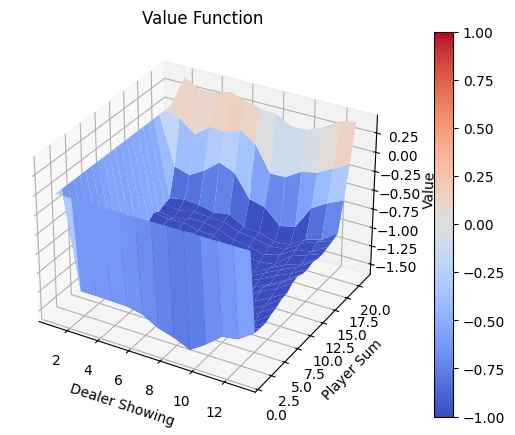

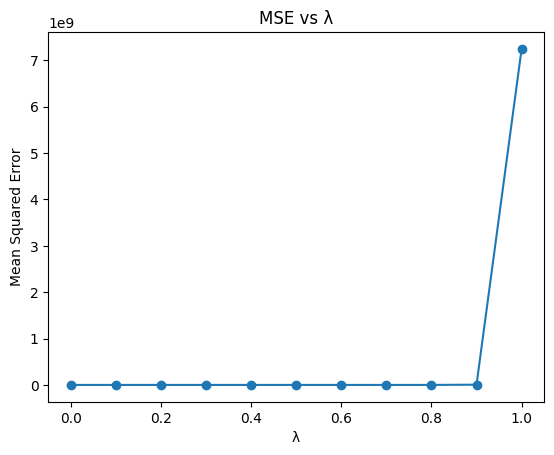

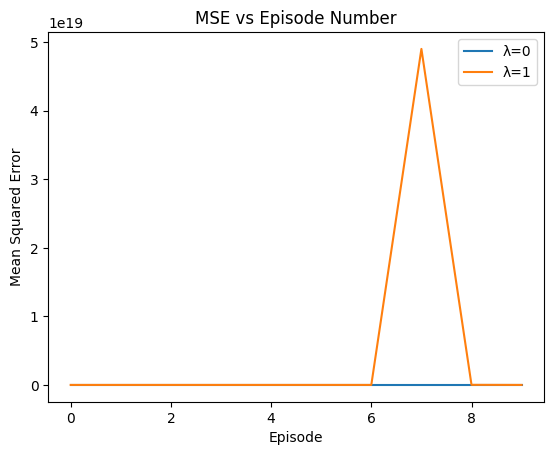

In [11]:
run_mc_control()
run_sarsa_lambda()
